In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
#import pystan

reload(misc)
reload(plotting)

first_year = 1992
last_year = 2012

use_body = True

data_dir = '.'
data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_05_25.csv')
data = misc.read_article_data(data_file, first_year, last_year, rename_frames=True, use_body=use_body)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_tone_annotations.csv'), first_year, last_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

framing_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_framing_annotations.csv'), first_year, last_year)
print "Loaded framing annotations for %d articles" % len(framing_annotations.index)
framing_annotations = misc.compute_entropy(framing_annotations)
#print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max()
print "Last date = ", last_date
last_year = last_date.year + 1


Loaded data for 33868 articles
Loaded tone annotations for 3857 articles
Loaded framing annotations for 4323 articles
Last date =  2012-12-31 00:00:00


1992
Loaded 70 polls
     Varname   House     Date  Topic  Subcode   L1    L2   L3   L4   C2  \
68   PSRAIMM    PSRA  5/28/92    120      124  6.0  15.0  0.0  0.0  0.0   
44  IMMLEGAL  CBSNYT  6/21/93    120      124  6.0  27.0  0.0  0.0  0.0   
16   IMMKEPT  GALLUP   7/9/93    120      124  6.0  27.0  0.0  0.0  0.0   
69   PSRAIMM    PSRA  7/13/94    120      124  5.0  12.0  0.0  0.0  0.0   
45  IMMLEGAL  CBSNYT   9/8/94    120      124  6.0  27.0  0.0  0.0  0.0   

      ...     fold       f_date  f_date_0  IMMKEPT  IMMLEGAL PSRAIMM  CNNIMM  \
68    ...        0  1992.407104  0.407104        0         0       1       0   
44    ...        1  1993.471233  1.471233        0         1       0       0   
16    ...        2  1993.520548  1.520548        1         0       0       0   
69    ...        3  1994.531507  2.531507        0         0       1       0   
45    ...        4  1994.687671  2.687671        0         1       0       0   

    SPIMMIG  IMMRATE  question  
68        0   

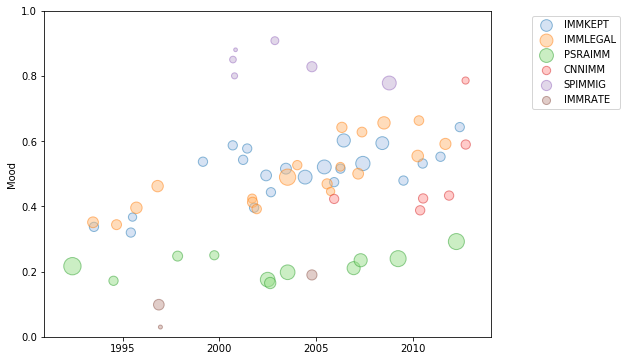

In [22]:
reload(misc)

#filename = 'immigration_polls.csv'
filename = 'immigration_polls_dedup_merge.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_year=last_year)

polls = misc.get_f_dates(polls, first_year, group_by='day')

print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
#questions = list(set(varnames))
#questions.sort()
questions = misc.get_top_poll_questions(polls, n=len(varnames)+1)
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = q_i
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 

reload(plotting)
#plotting.plot_polling_data(polls)

polls = polls[polls['date'] <= last_date]

fig, ax = plotting.plot_polling_data(polls, transform=False)
ax.set_ylabel('Mood')
#plt.savefig('/Users/dcard/Desktop/imm_polls.pdf', bbox_inches='tight')
#ax.plot(grouped.f_date, grouped.mood, label='Estimated mood')
plt.savefig('/Users/dcard/Desktop/imm_polls_with_mood.pdf', bbox_inches='tight')

Question	Responses


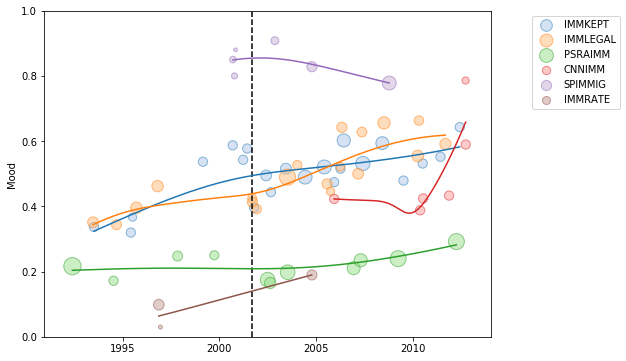

In [70]:
reload(misc)
#from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LinearRegression as LR
import datetime as dt
import statsmodels.api as sm


fig, ax = plotting.plot_polling_data(polls, transform=False)
ax.plot((sept_11, sept_11), (0, 1), 'k--')
ax.set_ylabel('Mood')

top_varnames = misc.get_top_poll_questions(polls)
for v_i, varname in enumerate(top_varnames):
    polls_v = polls[polls['Varname'] == varname]
    if v_i < 10:
        color=plotting.tableau20[v_i * 2]
    else:
        color='black'
    
    x = polls_v['p_day'].ravel()
    y = polls_v['value'].ravel()

    smoother = sm.nonparametric.KernelReg(y, x, var_type='c', reg_type='ll', bw='cv_ls')
    #smoother = KernelReg(y, x, var_type='c', reg_type='ll', bw='cv_ls')
    linear = LR()

    x_range = np.arange(x.min(), x.max())
    dates = misc.days_to_dates(x_range, first_year)
    f_dates = misc.dates_to_f_dates(dates, first_year, 'day')
    sept_11 = misc.dates_to_f_dates([pd.Timestamp(dt.datetime(2001, 9, 11))], first_year, 'day')

    kr_pred, _ = smoother.fit(x_range)
    linear.fit(np.reshape(x, (-1, 1)), y)
    linear_pred = linear.predict(np.reshape(x_range, (-1, 1)))
    
    ax.plot(f_dates, kr_pred, c=color)

    #ax.plot(f_dates, linear_pred, c=color, linestyle='--')



In [60]:
# first estimate the offset for each poll using a simple linear regression

cols = ['f_date_0'] + top_varnames[1:]
X = polls[cols].as_matrix()
y = polls['value'].ravel()

model = LR()
result = model.fit(X, y)
offsets = [0] + result.coef_[1:].tolist()
print offsets

[0, -0.003409733329813721, -0.2706055819897236, -0.06760632190279385, 0.3465354791234267, -0.34991138460085974]


Question	Responses


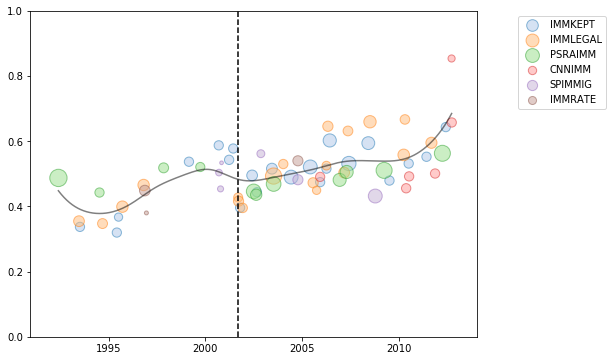

In [68]:
# then fit a single kernel regression to all the data after accounting for the offsets
reload(plotting)

polls['value_offset'] = 0
for i in polls.index:
    polls.loc[i, 'value_offset'] = polls.loc[i, 'value'] - offsets[top_varnames.index(polls.loc[i, 'Varname'])]

fig, ax = plotting.plot_polling_data(polls, transform=False, column='value_offset')
ax.plot((sept_11, sept_11), (0, 1), 'k--')

x = polls['p_day'].ravel()
y = polls['value_offset'].ravel()

smoother = KernelReg(y, x, var_type='c', reg_type='ll', bw='cv_ls')

x_range = np.arange(x.min(), x.max())
dates = misc.days_to_dates(x_range, first_year)
f_dates = misc.dates_to_f_dates(dates, first_year, 'day')
sept_11 = misc.dates_to_f_dates([pd.Timestamp(dt.datetime(2001, 9, 11))], first_year, 'day')
kr_pred, _ = smoother.fit(x_range)
ax.plot(f_dates, kr_pred, 'k', alpha=0.5)


In [57]:
# MODEL with no temporal covariates (just polls)

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);

p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1], sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [10]:
import pystan
#tones = grouped.tone.values
#n_periods = len(tones)
n_polls, _ = polls.shape
periods = np.array(polls.p_day, dtype=int) + 1
n_periods = max(periods)
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, int(polls.question.values[i])] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
#t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses


''

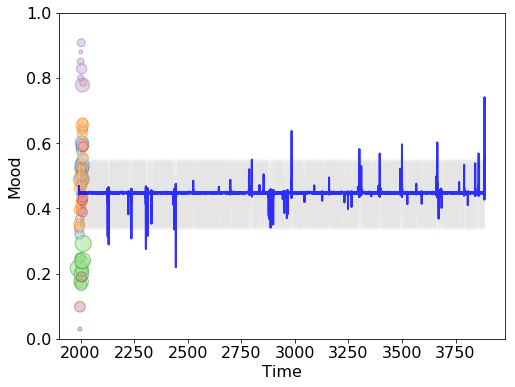

In [11]:
reload(plotting)
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls, legend=False)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.2, label=None)
#for i in range(n_chains):
#    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='Estimated mood')
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
#ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='Fit', alpha=0.5)
#for i in range(n_polls):
#    f_date = polls.f_date.iloc[i]
#    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
#ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.36,0.9))

#fit.plot('alpha')
#fit.plot('beta')
#fit.plot('gamma')
#fit.plot('offsets')

ax.set_ylabel('Mood')
ax.set_xlabel('Time')
plt.savefig('/Users/dcard/Desktop/imm_polls_with_bayesian_estimate.pdf', bbox_inches='tight')
""